In [1]:
%matplotlib inline

In [2]:
import athg4_parser as g4
import numpy as np
import glob
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import pandas as pd
import random as rm
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow import keras

/data/soft/anaconda/4.1.1/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
g4dir = 'gcr_protons/gcr'

In [4]:
def get_summed_image_cutout_cent(deps):
    x =[]
    y = []
    for part in deps:
        for dep in part:
            x.append(dep[0])
            y.append(dep[1])
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xcent, ycent = np.mean([xmin, xmax]), np.mean([ymin, ymax])
    sz_x, sz_y = 50, 50
    im = np.zeros((int(sz_x), int(sz_y)))
    for part in deps:
        for dep in part:
            ix = int(dep[0]) - int(xcent) + int(sz_x/2)
            iy = int(dep[1]) - int(ycent) + int(sz_y/2)
            if ix >=0 and ix < sz_x and iy >= 0 and iy < sz_y:
                im[ix, iy] += dep[2]*100  # offset pixels
    return im

In [5]:
events = []
num = 0
for fn in sorted(glob.glob(g4dir + '/*')):
    num += 1
    if(num > 10):
        break
    print(fn)
    try:
        events += g4.parse(fn)
    except:
        continue

# put the events into a pandas dataframe
gcr_df = g4.to_dataframe(events)
gcr_dfg = gcr_df.groupby('eid')

gcr_protons/gcr/100_detector0
gcr_protons/gcr/100_detector1
gcr_protons/gcr/100_detector2
gcr_protons/gcr/100_detector3
gcr_protons/gcr/10_detector0
gcr_protons/gcr/10_detector1
gcr_protons/gcr/10_detector2
gcr_protons/gcr/10_detector3
gcr_protons/gcr/11_detector0
gcr_protons/gcr/11_detector1


In [6]:
num = 0
gcr_im = []
gcr_labels = []
for eid in set(gcr_df.eid):
    im = get_summed_image_cutout_cent(gcr_dfg.get_group(eid).deps)
        
    num += 1
        
    gcr_im.append(im)
    
        
gcr_im = np.array(gcr_im)

In [7]:
evlfile = 'test.raw'

In [8]:
f = pyfits.open(evlfile)
df = pd.DataFrame({'FRAME' : f['EVENTS'].data['FRAME'].byteswap().newbyteorder('<'),
                   'PHA' : f['EVENTS'].data['PHA'].byteswap().newbyteorder('<'),
                   'RAWX' : f['EVENTS'].data['RAWX'].byteswap().newbyteorder('<'),
                   'RAWY' : f['EVENTS'].data['RAWY'].byteswap().newbyteorder('<'),
                   })
f.close()
df_byframe = df.groupby('FRAME')

In [9]:
def get_frame_image(fr):
    x = []
    y = []
    for i,r in df_byframe.get_group(fr).iterrows():
        x.append(r.RAWX)
        y.append(r.RAWY)
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xcent, ycent = np.mean([xmin, xmax]), np.mean([ymin, ymax])
    sz_x, sz_y = 50, 50
    im = np.zeros((int(sz_x), int(sz_y)))
    for i,r in df_byframe.get_group(fr).iterrows():
        ix = r.RAWX - int(xcent) + int(sz_x/2)
        iy = r.RAWY - int(ycent) + int(sz_y/2)
        if ix >=0 and ix < sz_x and iy >= 0 and iy < sz_y:
            im[ix, iy] += r.PHA  # offset pixels
    return im

In [10]:
num = 0
xr_im = []
xr_labels = []
lim = 20000
for fr in set(df.FRAME):
    num += 1
    if num > lim:
        break
    im = get_frame_image(fr)
        
    xr_im.append(im)
xr_im=np.array(xr_im)

I generate a train set randomly. Each figure contains 0-1 photon and 0-2 particles, which is recognized as a single cluster by DBSCAN. The label for a figure containing a photon is 1, otherwise the label is 0.

In [11]:
count=0
photon_index=0
particle_index=0
no_conn_num=0
train_im=[]
train_label=[]
while True:
    photon_num=rm.randint(0,1)
    particle_num=rm.randint(0,2)
    while photon_num==0 and particle_num==0:
        photon_num=rm.randint(0,1)
        particle_num=rm.randint(0,2)
    if photon_num==1:
        while np.nonzero(xr_im[photon_index])[0].shape[0]==0:
            photon_index+=1
        train_im.append(xr_im[photon_index].copy())
        photon_index+=1
        train_label.append(1)
    else:
        train_im.append(np.zeros((50,50)))
        train_label.append(0)
    if particle_num>=1:
        while np.nonzero(gcr_im[particle_index])[0].shape[0]==0:
            particle_index+=1
        dx=rm.randint(-3,3)
        dy=rm.randint(-3,3)
        im_shift=np.roll(gcr_im[particle_index],dx,axis=1)
        im_shift=np.roll(im_shift,dy,axis=0)
        train_im[count]+=im_shift
        particle_index+=1
    if particle_num==2:
        while np.nonzero(gcr_im[particle_index])[0].shape[0]==0:
            particle_index+=1
        dx=rm.randint(-3,3)
        dy=rm.randint(-3,3)
        im_shift=np.roll(gcr_im[particle_index],dx,axis=1)
        im_shift=np.roll(im_shift,dy,axis=0)
        train_im[count]+=im_shift
        particle_index+=1
    y_max=np.nonzero(train_im[count])[0].max()
    y_min=np.nonzero(train_im[count])[0].min()
    x_max=np.nonzero(train_im[count])[1].max()
    x_min=np.nonzero(train_im[count])[1].min()
    dx=-int((x_max+x_min)/2)+25
    dy=-int((y_max+y_min)/2)+25
    train_im[count]=np.roll(train_im[count],dx,axis=1)
    train_im[count]=np.roll(train_im[count],dy,axis=0)
    count+=1
    
    X=np.transpose(np.nonzero(train_im[count-1]))
    clustering = DBSCAN(eps=3, min_samples=3).fit(X)
    
    
    if np.unique(clustering.labels_).shape[0]>1:
        no_conn_num+=1
        count-=1
        if no_conn_num<8:
            photon_index-=photon_num
            particle_index-=particle_num
        del train_im[count]
        del train_label[count]
    else:
        no_conn_num=0
    
    if particle_index>=10000:
        break

In [12]:
train_im=np.array(train_im)
train_label=np.array(train_label)

The X-ray signal is much weaker than the particle signal. Therefore, in order to increase the prediction accuracy in later classification by deep learning, I set all non-zero elements of the train set to be a constant.

In [13]:
train_im_all1=np.copy(train_im)
train_im_all1[np.nonzero(train_im_all1)]=1

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(50, 50)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

#train_im = train_im.reshape(7500,50,50,1)
#test_im = test_im.reshape(4500,50,50,1)
model.fit(train_im_all1, train_label, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               640256    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 640,513
Trainable params: 640,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7906/7906 [==============================] - 1s 151us/step - loss: 0.1986 - acc: 0.9097
Epoch 2/5
7906/7906 [==============================] - 1s 106us/step - loss: 0.0471 - acc: 0.9867
Epoch 3/5
7906/7906 [==============================] - 1s 103us/step - loss: 0.0202 - acc: 0.9951
Epoch 4/5
7906/7906 [==============================] - 1s 102us/step - loss: 0.0124 - acc: 0.9978
Epoch 5/

I generate randomly a 500*500 screen of the detector before eliminating noises.

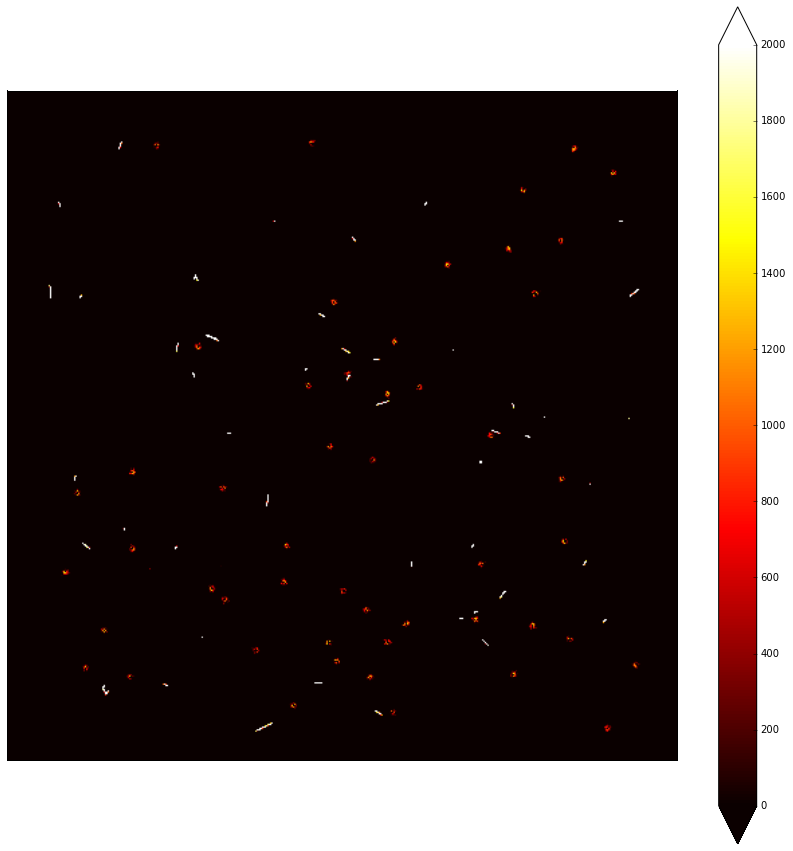

In [62]:
screen=np.zeros((500,500))
for im in gcr_im[particle_index:particle_index+50]:
    x_g=rm.randint(0,450)
    y_g=rm.randint(0,450)
    screen[x_g:x_g+50,y_g:y_g+50]+=im
for im in xr_im[photon_index:photon_index+50]:
    x_x=rm.randint(0,450)
    y_x=rm.randint(0,450)
    screen[x_x:x_x+50,y_x:y_x+50]+=im
plt.figure(figsize=(15,15))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(screen,cmap='hot')
plt.colorbar(extend='both')
plt.clim(0, 2000);
plt.show()

I use DBSCAN algorithm to cluster the screen and use the deep learning model I previously trained to predict whether each cluser contains a photon or not. If yes, the cluster will be kept, otherwise the cluster will be deleted from the screen.

In [63]:
X=np.transpose(np.nonzero(screen))
clustering = DBSCAN(eps=3, min_samples=3).fit(X)
test_im=[]
for value in np.unique(clustering.labels_):
    if value==-1:
        continue
    y_max=np.nonzero(screen)[0][clustering.labels_==value].max()
    y_min=np.nonzero(screen)[0][clustering.labels_==value].min()
    x_max=np.nonzero(screen)[1][clustering.labels_==value].max()
    x_min=np.nonzero(screen)[1][clustering.labels_==value].min()
    dx=25-int((x_max+x_min)/2)
    dy=25-int((y_max+y_min)/2)
    im=np.zeros((50,50))
    im[np.nonzero(screen)[0][clustering.labels_==value]+dy,np.nonzero(screen)[1][clustering.labels_==value]+dx]=screen[np.nonzero(screen)[0][clustering.labels_==value],np.nonzero(screen)[1][clustering.labels_==value]]
    test_im.append(im)
test_im=np.array(test_im)
test_im_all1=np.copy(test_im)
test_im_all1[np.nonzero(test_im_all1)]=1

In [64]:
predict=np.transpose(model.predict(test_im_all1,verbose=0))[0]
screen1=np.copy(screen)
for value in np.unique(clustering.labels_)[1:][predict<0.5]:
    screen1[np.nonzero(screen)[0][clustering.labels_==value],np.nonzero(screen)[1][clustering.labels_==value]]=0

This is the screen after eliminating noises.

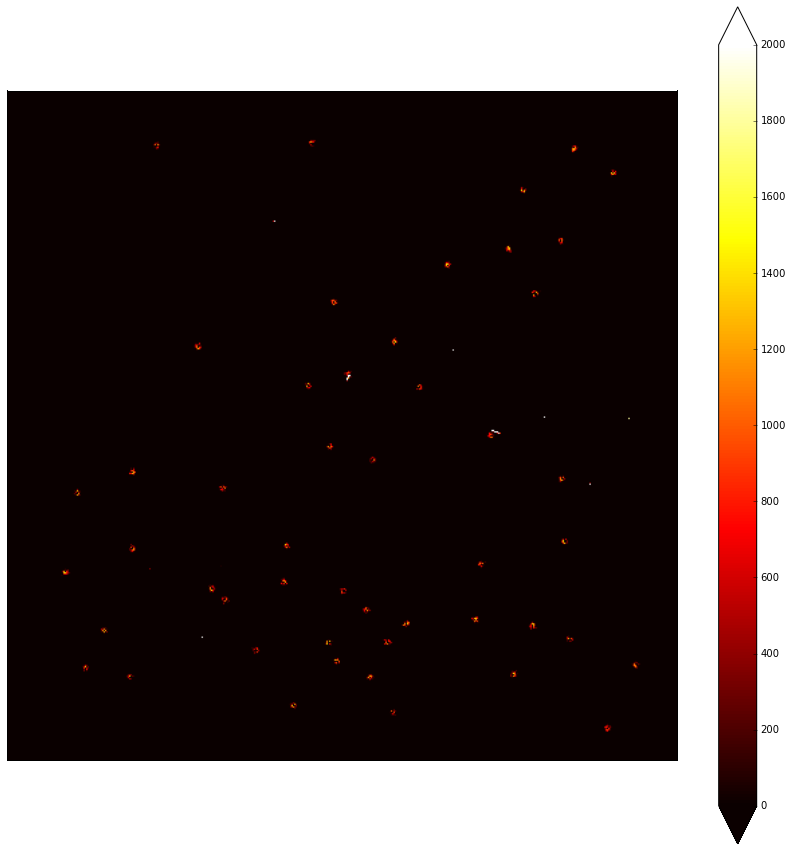

In [65]:
plt.figure(figsize=(15,15))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(screen1,cmap='hot')
plt.colorbar(extend='both')
plt.clim(0, 2000);
plt.show()

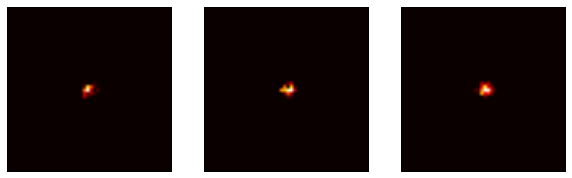

In [66]:
plt.figure(figsize=(10,10))
num=1
for im in xr_im[0:3]: 
        plt.subplot(1,3,num)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(im,cmap='hot')
        num+=1
plt.show()

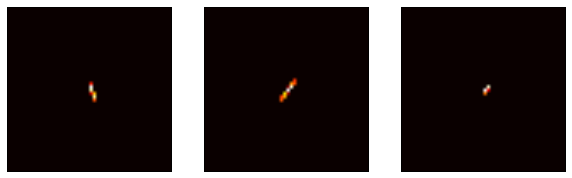

In [67]:
plt.figure(figsize=(10,10))
num=1
for im in gcr_im[600:603]: 
        plt.subplot(1,3,num)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(im,cmap='hot')
        num+=1
plt.show()

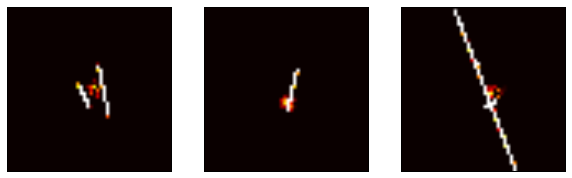

In [68]:
plt.figure(figsize=(10,10))
for num in range(1,4): 
        plt.subplot(1,3,num)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if num==1:
            plt.imshow(train_im[273],cmap='hot')
        if num==2:
            plt.imshow(train_im[611],cmap='hot')
        if num==3:
            plt.imshow(train_im[621],cmap='hot')
        plt.clim(0,2000)
plt.show()